# 人脸识别模型 FaceNet


## 使用基于 NN4 改造的 CNN 模型训练和提取特征


**nn4.small2.v1** 是 FaceNet 论文中描述的 NN4 模型的变体，在 OpenFace 的模型列表中有 [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) 详细介绍。

![](model_comparison.png)


### 模型列表

|Model | Number of Parameters |
| ---- | ---- |
| [nn4.small2](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.small2.def.lua) | 3733968 |
| [nn4.small1](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.small1.def.lua) | 5579520 |
| [nn4](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn4.def.lua) | 6959088 |
| [nn2](https://github.com/cmusatyalab/openface/blob/master/models/openface/nn2.def.lua) | 7472144 |


本教程使用其 [Keras版本](https://github.com/krasserm/face-recognition) 的一种实现，模型定义在 [model.py](model.py) ，模型可视化的图像存储在 [nn4_small2_model.png](nn4_small2_model.png) 。

### Retrain 人脸识别模型工作流程

1. 加载训练数据集
1. 人脸检测、对齐和提取（使用 OpenFace 的人脸对齐工具 AlignDlib）
1. 人脸特征向量学习（使用预训练的 nn4.small1.v1 模型)
1. 人脸分类（使用 KNN 或 SVM）


## 加载训练数据集

### 训练数据集组织形式

- 每人一个文件目录，目录以人名命名，如”Fan\_Bingbing“
- 每个人的文件目录下包含10张图像（最好是1:1比例），图像文件以"人名\_序号"命名，仅支持.jpg和.jpeg 两种格式。如”Fan\_Bingbing\_0001.jpg“。

In [17]:
import numpy as np

import cv2
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base # 数据集根目录
        self.name = name # 目录名
        self.file = file # 图像文件名

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_image_metadata(path):
    # path: base directory; i: person name; f: image file name (only process jpg and jpeg)
    metadata = []
    for i in os.listdir(path): 
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1] 
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV 默认使用 BGR 通道加载图像，转换为 RGB 图像
    return img[...,::-1]

In [18]:
metadata = load_image_metadata('images')

In [19]:
print(metadata)

[images/Deng_chao/Deng_chao_0010.jpg images/Deng_chao/Deng_chao_0004.jpg
 images/Deng_chao/Deng_chao_0005.jpg images/Deng_chao/Deng_chao_0007.jpg
 images/Deng_chao/Deng_chao_0006.jpg images/Deng_chao/Deng_chao_0002.jpg
 images/Deng_chao/Deng_chao_0003.jpg images/Deng_chao/Deng_chao_0001.jpg
 images/Deng_chao/Deng_chao_0008.jpg images/Deng_chao/Deng_chao_0009.jpg
 images/Fan_Bingbing/Fan_Bingbing_0008.jpg
 images/Fan_Bingbing/Fan_Bingbing_0009.jpg
 images/Fan_Bingbing/Fan_Bingbing_0007.jpg
 images/Fan_Bingbing/Fan_Bingbing_0006.jpg
 images/Fan_Bingbing/Fan_Bingbing_0010.jpg
 images/Fan_Bingbing/Fan_Bingbing_0004.jpg
 images/Fan_Bingbing/Fan_Bingbing_0005.jpg
 images/Fan_Bingbing/Fan_Bingbing_0001.jpg
 images/Fan_Bingbing/Fan_Bingbing_0002.jpg
 images/Fan_Bingbing/Fan_Bingbing_0003.jpg
 images/Di_lireba/Di_Lireba_0006.jpg images/Di_lireba/Di_Lireba_0007.jpg
 images/Di_lireba/Di_Lireba_0005.jpg images/Di_lireba/Di_Lireba_0004.jpg
 images/Di_lireba/Di_Lireba_0010.jpg images/Di_lireba/Di_Li

## 人脸检测、对齐和提取

从原图提取 96x96 RGB人脸图像。如果原图不是 1:1 比例，提取后的人脸会进行拉伸变换。

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

def plot_aligned_face(image_path): 
    # 初始化 OpenFace 人脸对齐工具，使用 Dlib 提供的 68 个关键点
    alignment = AlignDlib('face_detection/landmarks.dat')
    # 加载图片
    img = load_image(image_path)
    # 检测人脸并返回边框
    bb = alignment.getLargestFaceBoundingBox(img)
    # 使用指定的人脸关键点转换图像并截取出 96x96 的人脸图像，
    # 代码来自align.py，是从AlignDlib提取出的代码文件，这样就不用安装整个库了
    aligned_img = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    # 绘制原图
    plt.subplot(131)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    # 绘制带人脸边框的原图
    plt.subplot(132)
    plt.imshow(img)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
    plt.xticks([])
    plt.yticks([])
    # 绘制对齐后截取的 96x96 人脸图像
    plt.subplot(133)
    plt.imshow(aligned_img)
    plt.xticks([])
    plt.yticks([])

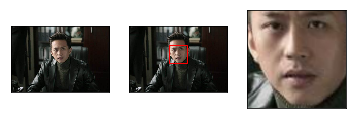

In [21]:
plot_aligned_face(metadata[0].image_path())

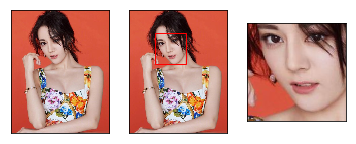

In [22]:
plot_aligned_face(metadata[20].image_path())

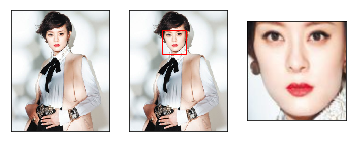

In [23]:
plot_aligned_face(metadata[30].image_path())

### 加载 nn4.small2.v1 模型

![](facenet_architect.png)

In [24]:
# 代码在model.py中，把nn4 small2的数据流图重建出来
from model import create_model
nn4_small2 = create_model()

In [25]:
from keras.models import Model
from keras.layers import Input, Layer

# 输入占位符 anchor, positive and negative 96x96 RGB图像
# Tripple Loss三元组对应的图像
# in_a: 基本人脸图像 
# in_p: 与基本人脸最不像的正确人脸图像
# in_n: 与基本人脸最像的错误人脸图像
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# 输出对应的人脸特征向量
# emb_a: in_a对应的特征
# emb_b: in_b对应的特征
# emb_c: in_c对应的特征
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

In [26]:
# if plot_model fail with log "`pydot` failed to call GraphViz", install graphviz first
# !apt install -y graphviz

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(nn4_small2, to_file='nn4_small2_model.png', show_shapes=True)

model plot: [nn4_small2_model.png](./nn4_small2_model.png)

## Triplet Loss Layer

模型训练的目标是学习出一个将人脸图像嵌入到欧几里得特征空间的函数 $f(x)$，使得对于特定人脸图像 $x$ ，同一人不同人脸的欧式距离（Squared L2 Distance）尽可能小，不同人直接的欧式距离尽可能大。

通过最小化 *triplet loss* $L$ 可以学习到我们想要的模型：

$$L = \sum^{N}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ 即 $max(z,0)$ , $N$ 是三元组集合的基数。

**下面使用 Keras 的自定义 Loss 来实现 Triplet Loss**

In [28]:
from keras import backend as K

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha # alpha是Positive与Negative的边界
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs # a:基本人脸; p:最不像的正确人脸; n:最像的错误人脸
        p_dist = K.sum(K.square(a-p), axis=-1) # p_dist: 基本人脸 到 最不像的正确人脸 的距离
        n_dist = K.sum(K.square(a-n), axis=-1) # n_dist: 基本人脸 到 最像的错误人脸 的距离
        # 希望经过训练之后，n_dist - p_dist非常大，因此给违背这个目标的triplet一个损失值
        # 根据下面的公式，当p_dist - n_dist > alpha时，损失值>0；其他情况下损失值 = 0
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# triplet_loss_layer: 输入是nn4_small2_train产出的特征，输出是triplet_loss损失值
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# 为nn4_small2_train增加输入层(3个输入图像占位符)，损失层(triplet_loss_layer)
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [29]:
# plot新的model数据流图
plot_model(nn4_small2_train, to_file='nn4_small2_train_with_loss_layer_and_input.png', show_shapes=True)

模型数据流图: [nn4_small2_train_with_loss_layer_and_input.png](./nn4_small2_train_with_loss_layer_and_input.png)

图中间的model_1:Model就是之前[nn4_small2_model.png](./nn4_small2_model.png)绘制出的nn4数据流图

## 加载预训练模型 nn4.small2.v1

我们从 OpenFace 提供的 [预训练模型](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) 中选择 **nn4.small2.v1**。

这些模型使用公开数据集 [FaceScrub](http://vintage.winklerbros.net/facescrub.html) 和 [CASIA-WebFace](http://arxiv.org/abs/1411.7923)进行训练。Keras-OpenFace 项目将这些模型文件转换为 [csv 文件](https://github.com/iwantooxxoox/Keras-OpenFace/tree/master/weights)，然后我们将其转换为 Keras h5 模型文件 [nn4.small2.v1.h5](models/nn4.small2.v1.h5)。

转换工具应当是：https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/Keras-openface-convertion.ipynb

### 预训练模型

| Model         | alignment `landmarkIndices`                    |
| ---- | ---- |
| nn4.v1        | `openface.AlignDlib.INNER_EYES_AND_BOTTOM_LIP` |
| nn4.v2        | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |
| nn4.small1.v1 | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |
| nn4.small2.v1 | `openface.AlignDlib.OUTER_EYES_AND_NOSE`       |


In [40]:
# 加载nn4预训练模型
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('models/nn4.small2.v1.h5')

In [43]:
# 截取并返回96*96对齐后的人脸
def align_image(img, alignDlib):
    # 检测人脸并返回边框
    face_boarder = alignDlib.getLargestFaceBoundingBox(img)
    # 使用指定的人脸关键点转换图像并截取出 96x96 的人脸图像 (代码见align.py,是从AlignDlib提取的代码文件)
    return alignDlib.align(96, img, face_boarder, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [44]:
# 图片文件路径：人名(metadata)可以从文件路径中提取
metadata = load_image_metadata('orig_images')
# N张图片的128维人脸特征向量
embedded = np.zeros((metadata.shape[0], 128))
# AlignDlib
alignDlib = AlignDlib('face_detection/landmarks.dat')
# 遍历图片，用预训练模型（不含trippletloss层）得到所有图片的人脸特征向量
for i, m in enumerate(metadata):
    # 截取并对齐图片中的人脸
    img = load_image(m.image_path())
    img = align_image(img, alignDlib)
    # 数据规范化
    img = (img / 255.).astype(np.float32)
    # 人脸特征向量
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

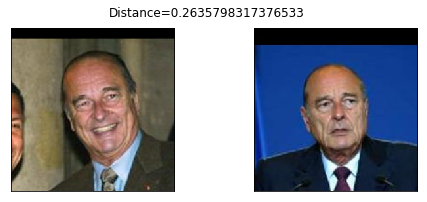

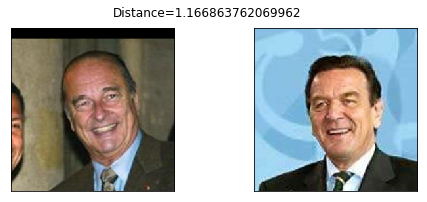

In [45]:
# 欧式距离
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

# 计算两张图片nn4特征的欧式距离
def show_pair(idx1, idx2):
    distance_value = distance(embedded[idx1], embedded[idx2])
    plt.figure(figsize=(8,3))
    plt.suptitle('Distance={0}'.format(distance_value))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))
    plt.xticks([])
    plt.yticks([])

# 比较图片之间的特征距离，发现相同人脸的距离近
show_pair(2, 3)
show_pair(2, 12)

## 人脸分类

In [46]:
#!pip install sklearn

(1) 加载Lib

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

(2)从文件路径中提取人名，用做样本的标签，并用数字编码

In [63]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)
y = encoder.transform(targets) 

print(targets[:3], y[:3])
print(targets[-3:], y[-3:])

['Jacques_Chirac' 'Jacques_Chirac' 'Jacques_Chirac'] [7 7 7]
['George_W_Bush' 'George_W_Bush' 'George_W_Bush'] [4 4 4]


(3) 训练集、测试集拆分

In [64]:
# 用来拆分训练集、测试集索引数组
train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# X: 是预训练模型输出的nn4特征
X_train = embedded[train_idx] # 50 train examples of 10 identities (5 examples each)
X_test = embedded[test_idx]   # 50 test examples of 10 identities (5 examples each)

# Y：是样本标签（人名的数字表示）
y_train = y[train_idx]
y_test = y[test_idx]

(4) 用knn和svc各训练一个模型，并计算训练集准确度

In [65]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print('KNN accuracy = {0}, SVM accuracy = {1}'.format(acc_knn,acc_svc))

KNN accuracy = 0.96, SVM accuracy = 0.98


(5) 人脸识别样例

([], <a list of 0 Text yticklabel objects>)

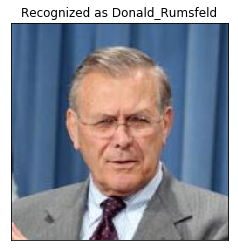

In [66]:
import warnings
warnings.filterwarnings('ignore')

example_idx = 44

example_image = load_image(metadata[example_idx].image_path())
example_prediction = svc.predict([embedded[example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title('Recognized as {0}'.format(example_identity))
plt.xticks([])
plt.yticks([])

## 模型测试与可视化分析

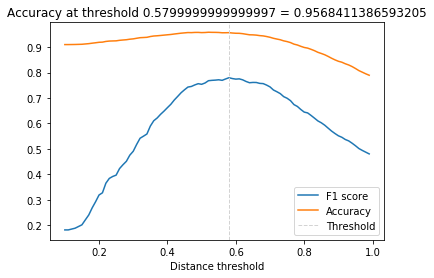

In [67]:
from sklearn.metrics import f1_score

# 图片特征距离，以及是否是同一个人
distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
for i in range(len(metadata) - 1):
    for j in range(1, len(metadata)):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
distances = np.array(distances)
identical = np.array(identical)

# 阈值数组，从0.1到1.0，阈值之间间隔0.01
thresholds = np.arange(0.1, 1.0, 0.01)

# 不同阈值下的准确率，和F1分数（F1 = 2 / (1/准确率 + 1/召回率))
f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

# 最佳阈值
opt_tau = thresholds[np.argmax(f1_scores)] # 最大F1值对应的阈值
opt_acc = accuracy_score(identical, distances < opt_tau) # 最大F1值对应的准确率

# 绘制F1值和准确率与 threshold 间关系
plt.plot(thresholds, f1_scores, label='F1 score')
plt.plot(thresholds, acc_scores, label='Accuracy')
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Accuracy at threshold {0} = {1}'.format(opt_tau, opt_acc))
plt.xlabel('Distance threshold')
plt.legend()

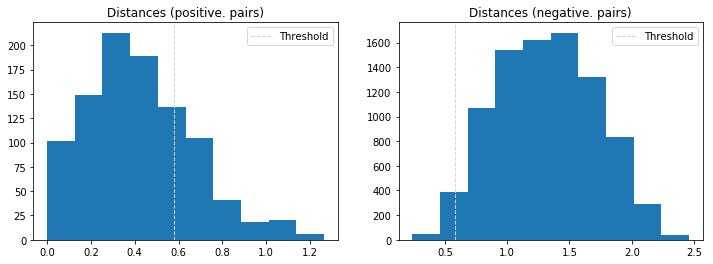

In [54]:
# 相同人的图片之间的特征距离
dist_pos = distances[identical == 1]
# 不同人的图片之间的特征距离
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold') #最佳F1分数对应的阈值
plt.title('Distances (positive. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold') #最佳F1分数对应的阈值
plt.title('Distances (negative. pairs)')

plt.legend();

## 降维人脸特征向量

([], <a list of 0 Text yticklabel objects>)

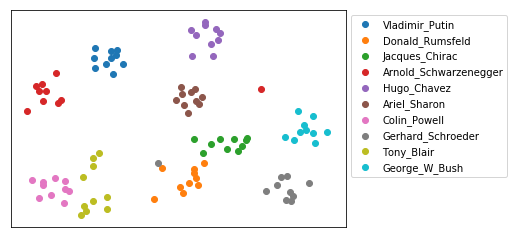

In [68]:
from sklearn.manifold import TSNE

# 用TSNE对特征降维，降低到二维
# TSNE（t-分布随机近邻潜入）：降维的同时，试图让相似的实例彼此靠近，不相似的实例彼此远离。
# 主要用于可视化，尤其是高维空间的实例集群可视化（如MNIST图像的二维可视化）
X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));
plt.xticks([])
plt.yticks([])